In [1]:
import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from tqdm import tqdm

plt.style.use('seaborn')

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets

/home/faris/miniconda3/envs/cudalab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.cuda.is_available()

True

### Pipeline
  - Data:
      - Load dataset
      - DataLoader
      - Visualize dataset samples
  - Design Model:
      - Model Architecture
      - Forward Pass
  - Define Loss Function
  - Define Optimizer
  - Train:
      - Forward Pass (compute activations and loss)
      - Backward Pass (compute gradients)
      - Update Weights

# Dataset

In [4]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [5]:
train_dataset = datasets.CIFAR10(root='./data/CIFAR10', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data/CIFAR10', train=False, transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
print(type(train_dataset))
print(type(test_dataset))

<class 'torchvision.datasets.cifar.CIFAR10'>
<class 'torchvision.datasets.cifar.CIFAR10'>


In [7]:
print(len(train_dataset))
print(len(test_dataset))

50000
10000


In [8]:
print(train_dataset[0][0].shape)
print(train_dataset[0][1])

torch.Size([3, 32, 32])
6


# DataLoader

In [9]:
# Fitting data loaders for iterating
BATCH_SIZE = 64

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True) 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=False)

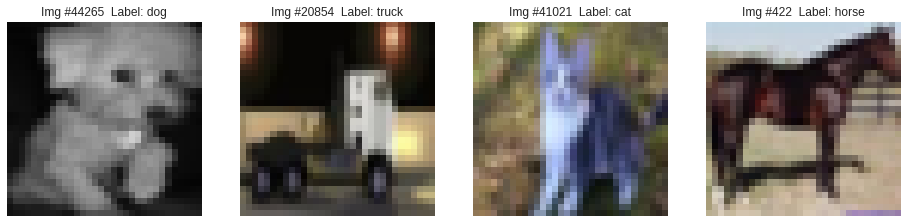

In [12]:
N_IMGS = 4
fig, ax = plt.subplots(1, N_IMGS)
fig.set_size_inches(4 * N_IMGS, 4)

cifar10_labels = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

ids = np.random.randint(low=0, high=len(train_dataset), size=N_IMGS)

for i, n in enumerate(ids):
    #img = train_dataset[n][0].numpy().transpose(1, 2, 0)
    img = train_dataset[n][0].permute(1, 2, 0)
    label_idx = train_dataset[n][1]
    label_name = cifar10_labels[label_idx]
    
    ax[i].imshow(img)
    ax[i].set_title(f"Img #{n}  Label: {label_name}")
    ax[i].axis("off")
plt.show()

In [11]:
it = iter(train_loader)
current_batch = next(it)
print(current_batch[0].shape) # batch x
print(len(current_batch[1])) # batch y

torch.Size([64, 3, 32, 32])
64


# Model

In [ ]:
class CNN(nn.Module):
    """ 
    Varation of LeNet: a simple CNN model
    for handwritten digit recognition
    """
    def __init__(self):
        super().__init__()
        
        conv1 = nn.Conv2d(in_channels=3, out_channels=20, kernel_size=3, stride=1, padding=0)
        relu1 = nn.ReLU()
        maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.layer1 = nn.Sequential(
                conv1, relu1, maxpool1
        )
      
        conv2 = nn.Conv2d(in_channels=20, out_channels=32, kernel_size=3, stride=1, padding=0)
        relu2 = nn.ReLU()
        maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.layer2 = nn.Sequential(
                conv2, relu2, maxpool2
        )

        conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=0)
        relu3 = nn.ReLU()
        maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.layer3 = nn.Sequential(
                conv3, relu3, maxpool3
        )
        
        self.fc1 = nn.Linear(in_features=32*2*2, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=10)
        
    def forward(self, x):
        batch_length = x.shape[0]

        out1 = self.layer1(x)
        out2 = self.layer2(out1)
        out3 = self.layer3(out2)
        
        # Flatten (for MLP)
        out3_flat = out3.view(batch_length, -1)
        y1 = self.fc1(out3_flat)
        y2 = self.fc2(y1)
        return y2

In [ ]:
class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16 (C,H,W)

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8 (C,H,W)

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4 (C,H,W)

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, x_batch):
        return self.network(x_batch)

In [ ]:
class CNN3(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),  # Dropout added after the first convolutional layer
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),  # Dropout added after the second convolutional layer
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),  # Dropout added after the third convolutional layer
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),  # Dropout added after the fourth convolutional layer
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),  # Dropout added after the 5th convolutional layer
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),  # Dropout added after the 6th convolutional layer
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # Dropout added after the first fully connected layer
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # Dropout added after the second fully connected layer
            nn.Linear(512, 10))
        
    def forward(self, x_batch):
        return self.network(x_batch)

In [ ]:
def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

In [ ]:
model = CNN3()
params = count_model_params(model)

In [ ]:
model

In [ ]:
params

# Metrics

In [ ]:
@torch.no_grad()
def eval_model(model):
    """ Computing model accuracy """
    correct = 0
    total = 0
    loss_list = []
    
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass only to get logits/output
        outputs = model(images)
                 
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
            
        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        correct += len(torch.where(preds==labels)[0])
        total += len(labels)
                 
    # Total correct predictions and loss
    accuracy = correct / total * 100
    loss = np.mean(loss_list)
    return accuracy, loss

In [ ]:
def save_model(model, optimizer, epoch, stats):
    """ Saving model checkpoint """
    
    if(not os.path.exists("models")):
        os.makedirs("models")
    savepath = f"models/checkpoint_epoch_{epoch}.pth"

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'stats': stats
    }, savepath)
    return

# Training

In [ ]:
LR = 3e-4
EPOCHS = 15

In [ ]:
EVAL_FREQ = 1
SAVE_FREQ = 10

In [ ]:
stats = {
    "epoch": [],
    "train_loss": [],
    "train_accuracy": [],
    "eval_loss": [],
    "eval_accuracy": []
}

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)

In [ ]:
for epoch in range(EPOCHS):
    loss_list = []
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    train_total = 0
    train_correct = 0
    # BATCH
    for i, (images, labels) in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = model(images)
         
        # Calculate Loss (SOFTMAX is already included in CrossEntropyLoss)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Accuracy
        preds = torch.argmax(outputs, dim=1)
        train_correct += len(torch.where(preds==labels)[0])
        train_total += len(labels)
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
             
    train_epoch_loss = np.mean(loss_list)
    train_accuracy = train_correct / train_total * 100
    stats["epoch"].append(epoch)
    stats["train_loss"].append(train_epoch_loss)
    stats["train_accuracy"].append(train_accuracy)
    
    # evaluating model
    if epoch % EVAL_FREQ == 0:
        eval_accuracy, eval_epoch_loss = eval_model(model)  
    else:   
        eval_accuracy, eval_epoch_loss = -1, -1
        
    stats["eval_accuracy"].append(eval_accuracy)
    stats["eval_loss"].append(eval_epoch_loss)
    
    # saving checkpoint
    #if epoch % SAVE_FREQ == 0:
        #save_model(model=cnn, optimizer=optimizer, epoch=epoch, stats=stats)

In [ ]:
epochs = np.array(stats["epoch"])
train_loss = np.array(stats["train_loss"])
train_accuracy = np.array(stats["train_accuracy"])

eval_loss = np.array(stats["eval_loss"])
eval_accuracy = np.array(stats["eval_accuracy"])
eval_idx = np.where(eval_loss != -1)[0]

# Plotting

In [ ]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(16,5)


ax.plot(epochs+1, train_loss, label="Train Loss", linewidth=3)
ax.plot(epochs[eval_idx]+1, eval_loss[eval_idx], c="red", label="Eval Loss", linewidth=3)
#ax.scatter(epochs[eval_idx]+1, eval_loss[eval_idx], c="red", s=100, marker="x")
ax.legend(loc="best")
ax.set_xlabel("Epochs")
ax.set_ylabel("CE Loss value")

ax.set_title("Training-Eval Progress")

plt.show()

In [ ]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,5)

ax[0].plot(epochs[eval_idx]+1, eval_accuracy[eval_idx], color="red", linestyle='-', marker='X', markersize=10, linewidth=1, label="Accuracy")
ax[0].legend(loc="best")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Classification Accuracy")
ax[0].set_title("Evaluation Accuracy Progress")

ax[1].plot(epochs+1, train_accuracy, color="blue", linestyle='-', marker='X', markersize=10, linewidth=1, label="Accuracy")
ax[1].legend(loc="best")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Classification Accuracy")
ax[1].set_title("Training Accuracy Progress")

plt.show()